# Variational Autoencoder (VAE)

Useful links: 
* Original paper http://arxiv.org/abs/1312.6114
* Helpful videos explaining the topic 
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

### Download data

In [1]:
#!L
from yfile import download_from_yadisk
import os

TARGET_DIR = '.'
FILENAME = "celeba.zip"

if not os.path.exists(os.path.join(TARGET_DIR, FILENAME)):
    # we are going to download 1.4 gb file, downloading will take some time (8-10 minutes)
    download_from_yadisk(
        short_url='https://disk.yandex.ru/d/QErNx-MoC-2Y6Q',
        filename=FILENAME,
        target_dir=TARGET_DIR
    )

    # alternative way: 
    #from gfile import download_list
    #download_list(url=https://drive.google.com/file/d/1lwn2JMwWNGloGvyzKUOcewT8JqP1ICoW,
    #               filename=FILENAME, target_dir=TARGET_DIR)

filesize = os.path.getsize(os.path.join(TARGET_DIR, FILENAME))
GB = 2**30
assert filesize > 1 * GB, "{filesize} is too small, something wrong with downloading"

In [3]:
#!L:bash
# !unzip celeba.zip

## Prepare the data

In [1]:
#!L
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.utils import make_grid

device = torch.device("cuda")

In [2]:
#!L
class CropCelebA64:
    
    def __call__(self, pic):
        new_pic = pic.crop((15, 40, 178 - 15, 218 - 30))
        return new_pic

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [3]:
#!L
# Note that for simplicity we reduce the number of channels to 1
# But if you want to be hardcore feel free to comment .Grayscale :)

train_dataset = torchvision.datasets.CelebA(
    root='celeba',
    split='train',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        
        torchvision.transforms.Grayscale()
    ]),
    #download=True,   # in case of problems with downloading from gdrive above
)

validation_dataset = torchvision.datasets.CelebA(
    root='celeba',
    split='valid',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.ToTensor(),
        
        torchvision.transforms.Grayscale()
    ]),
)

In [4]:
#!L
# Save first 10k images for evaluation
num_images = 10000
real_images_tensor = torch.stack([train_dataset[i][0] for i in range(num_images)], dim=0)
real_images = real_images_tensor.data.numpy().transpose([0, 2, 3, 1])
np.savez("real.npz", Pictures=real_images.reshape(num_images, 64 * 64 * 1))

In [5]:
#!L
BATCH_SIZE = 64

# you may find useful parameters `num_workers` and `pin_memory`
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE)

# Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:

In [6]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.shape[0], -1)

In [7]:
# #!L
dimZ = 100  # Considering face reconstruction task, which size of representation seems reasonable?

# # Define the decoder and encoder as networks with one hidden fc-layer
# # (that means you will have 2 fc layers in each net)
# # Use ReLU for hidden layers' activations
# # GlorotUniform initialization for W
# # Zero initialization for biases
# # It's also convenient to put sigmoid activation on output layer to get nice normalized pics


class Autoencoder(nn.Module):
    
    def __init__(self):
        super(Autoencoder, self).__init__()

        # TODO
        self.flatten = Flatten()
        
        self.encoder = nn.Sequential(
            nn.Linear(4096, 1024),
            nn.ReLU(),

            nn.Linear(1024, 100),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(100, 1024),
            nn.ReLU(),
            
            nn.Linear(1024, 4096),
            nn.Sigmoid(),
        )

    def forward(self, x):

        # TODO
        batch_size = x.shape[0]
        latent_code = self.encoder(self.flatten(x))  
        reconstruction = self.decoder(latent_code).reshape((batch_size, 1, 64, 64))      

        return reconstruction, latent_code

In [8]:
#!g1.1
def weights_init(layer):
    if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.ConvTranspose2d):
        nn.init.xavier_uniform_(layer.weight, 1.)
    if isinstance(layer, nn.Linear):
        nn.init.xavier_uniform_(layer.weight, 1.)
        nn.init.xavier_uniform_(layer.bias, 0)

In [9]:
from itertools import islice


autoencoder = Autoencoder().to(device)
images, _ = list(islice(val_loader, 1))[0]
reconstruction, latent_code = autoencoder(images.to(device))

assert reconstruction.shape == torch.Size([64, 1, 64, 64])
assert latent_code.shape == torch.Size([64, 100]), latent_code.shape

In [10]:
#!L
# Create MSE loss function
criterion = torch.nn.MSELoss()

autoencoder = Autoencoder().to(device)

# Use Adam optimizer
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-4)

In [11]:
#!L
# Train your autoencoder
# Visualize progress in reconstruction and loss decay

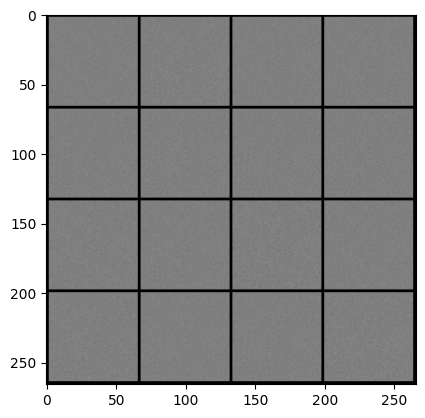

In [12]:
#!L
# Examine the reconstructions
from itertools import islice

images, _ = list(islice(val_loader, 1))[0]
reconstruction, latent_code = autoencoder(images.to(device))

reconstruction = reconstruction[:16].cpu()
plt.imshow(make_grid(reconstruction, nrow=4).permute(1, 2, 0))

epoch: 9
loss for epoch: 0.00487
val metric: 0.00171


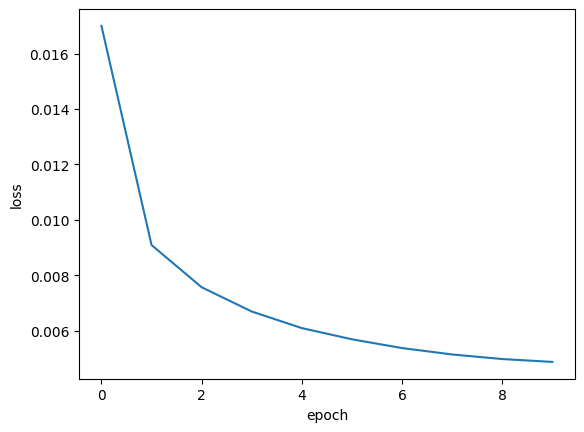

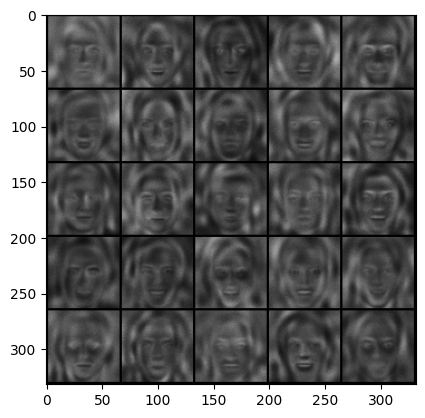

In [16]:
from IPython import display
from tqdm.auto import tqdm


losses_for_epochs = []
min_loss = 1000000.

for epoch in tqdm(range(10)):
    losses = []
    autoencoder.train()
    for x, y in tqdm(train_loader):
        x = x.to(device)
        optimizer.zero_grad()
        
        reconstruction, latent_code = autoencoder(x)
        loss = criterion(x, reconstruction)
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()

    if np.mean(losses) < min_loss:
        min_loss = np.mean(losses)
        torch.save(autoencoder.state_dict(), "autoencoder.pth")

    losses_for_epochs.append(np.mean(losses))


    autoencoder.eval()
    with torch.no_grad():
        val_metric = []
        for x, y in tqdm(val_loader):
            x = x.to(device)
            reconstruction, latent_code = autoencoder(x.to(device))

            val_metric.append((reconstruction - x).mean().item())
            
    
    display.clear_output(wait=True)
    
    print(f'epoch: {epoch}')
    print(f'loss for epoch: {round(np.mean(losses), 5)}')
    print(f'val metric: {round(np.mean(val_metric), 5)}')
    
    plt.plot(losses_for_epochs)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
    with torch.no_grad():
        z = torch.randn(25, 100) * 0.5
        reconstruction = autoencoder.decoder(z.to(device)).reshape((25, 1, 64, 64)).clamp(0, 1)
        
    plt.imshow(make_grid(reconstruction.cpu(), nrow=5).permute(1, 2, 0))
    plt.show()

Reconstruction is not bad, right? 

# Sampling

Let's now sample several latent vectors and perform inference from $z$, reconstruct an image given some random $z$ representations.

So, if we sample $z$ from normal, whould we eventually generate all possible faces? What do you think?

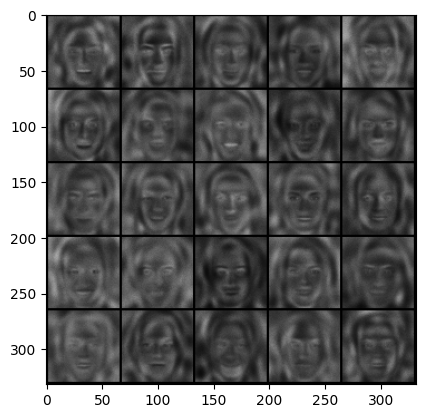

In [18]:
#!L
z = torch.randn(25, dimZ) * 0.5
reconstruction = autoencoder.decoder(z.to(device)).reshape((25, 1, 64, 64)).clamp(0, 1)

plt.imshow(make_grid(reconstruction.cpu(), nrow=5).permute(1, 2, 0))

# Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution $q(z|x)$. In our case distribution $q$ is Gaussian distibution $N(\mu, \sigma)$ with parameters $\mu$, $\sigma$. Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick should be implemented using the **gaussian_sampler** layer, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon \sim N(\mu, \sigma)$ .

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average them.

In [45]:
# #!L
# # to compare with conventional AE, keep these hyperparameters
# # or change them for the values that you used before
dimZ = 100

# # define the network
# # you can start from https://github.com/pytorch/examples/blob/master/vae/main.py
# # or Theano-based examples here https://github.com/Lasagne/Recipes/blob/master/examples/variational_autoencoder/variational_autoencoder.py
# # and here https://github.com/y0ast/Variational-Autoencoder/blob/master/VAE.py
# # but remember that this is not your ground truth since the data is not MNIST


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.flatten =  Flatten()

        self.encoder = nn.Sequential(
            nn.Linear(4096, 512),
            nn.LeakyReLU(0.1),

            nn.Linear(512, 512),
            nn.LeakyReLU(0.1),
        )

        self.z_mu = nn.Linear(512, 100)
        self.z_logsigma = nn.Linear(512, 100)


        self.decoder = nn.Sequential(
            nn.Linear(100, 2048),
            nn.LeakyReLU(0.1),

            nn.Linear(2048, 2048),
            nn.LeakyReLU(0.1),
        )

        self.gen_mu = nn.Linear(2048, 4096)
        self.gen_logsigma = nn.Linear(2048, 4096)


    def encod(self, x):
        x = self.flatten(x)
        latent = self.encoder(x)

        latent_mu = self.z_mu(latent)
        latent_logsigma = self.z_logsigma(latent)

        return latent_mu, latent_logsigma

    def decod(self, z):
        d = self.decoder(z)

        reconstruction_mu = torch.sigmoid(self.gen_mu(d))

        # без такой активации тут модель учится хуже и лица тоже не очень хороши
        reconstruction_logsigma = torch.tanh(self.gen_logsigma(d))

        return reconstruction_mu, reconstruction_logsigma

    def gaussian_sampler(self, mu, logsigma):
        noise = torch.randn_like(mu)
        return noise * torch.exp(logsigma) + mu

    def forward(self, x):
        latent_mu, latent_logsigma = self.encod(x)
        z = self.gaussian_sampler(latent_mu, latent_logsigma)
        reconstruction_mu, reconstruction_logsigma = self.decod(z)
        return reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z) \to max$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_i-x)^2}{2\sigma_i^2}} \Big)=...$$

Don't forget in the code that you are using $\log\sigma$ as variable. Explain, why not $\sigma$?

In [46]:
#!L
import math


def KL_divergence(mu, logsigma):
    return 0.5 * torch.sum(mu.pow(2) + logsigma.exp() ** 2 - 1 - 2 * logsigma, axis=1)


def log_likelihood(x, mu, logsigma):
    x = Flatten()(x)

    sigma = torch.exp(logsigma)
    sigma_square = torch.square(sigma)

    slog_1 = -x.shape[1] * math.log((2 * math.pi) ** 0.5) / 2
    slog_2 = -logsigma.sum(axis=1)
    slog_3 = (-torch.square(mu - x) / (2 * sigma_square)).sum(axis=1)

    return slog_1 + slog_2 + slog_3


def loss_vae(x, mu_gen, logsigma_gen, mu_z, logsigma_z, reduction='sum'):
    if reduction == 'sum':
        return -((log_likelihood(x, mu_gen, logsigma_gen) - KL_divergence(mu_z, logsigma_z))).sum()
    elif reduction == "mean":
        return -((log_likelihood(x, mu_gen, logsigma_gen) - KL_divergence(mu_z, logsigma_z))).mean()

In [50]:
vae = VAE().to(device)
reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma = vae(images.to(device))
loss_sum = loss_vae(images.to(device), reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma, "sum")
mean_loss = loss_vae(images.to(device), reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma, "mean")

loss_sum.item(), mean_loss.item()

(259413.53125, 2026.668212890625)

And train the model:

In [37]:
#!L
# train your variational autoencoder
# visualize progress in reconstruction and loss decay

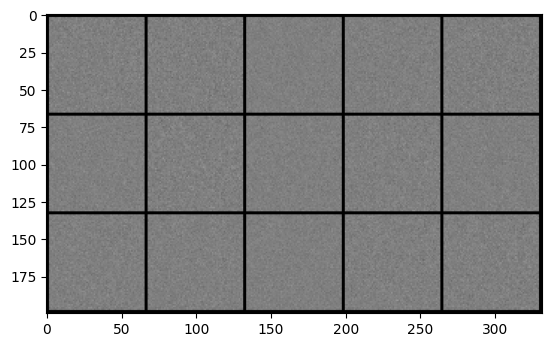

In [51]:
#!L
vae = VAE().to(device)
images, _ = list(islice(val_loader, 1))[0]
mu_gen, _, _, _ = vae(images.to(device))
reconstruction = mu_gen[:15].reshape((15, 1, 64, 64)).cpu().clamp(0, 1)

plt.imshow(make_grid(reconstruction, nrow=5).permute(1, 2, 0))

And finally sample from VAE.

In [27]:
#!L
# TODO
# Sample some images from the learned distribution
# 1) Sample z ~ N(0,1)
# 2) Sample from N(decoder_mu(z), decoder_sigma(z))

In [57]:
BATCH_SIZE = 128

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE)

In [78]:
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-03.


epoch: 9
loss for epoch: -258925.38459
min loss: -258925.38459


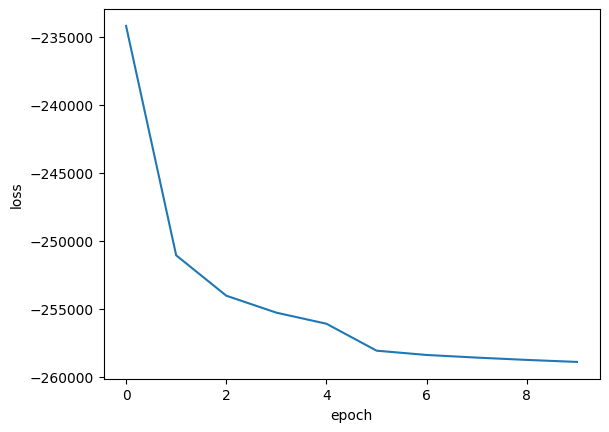

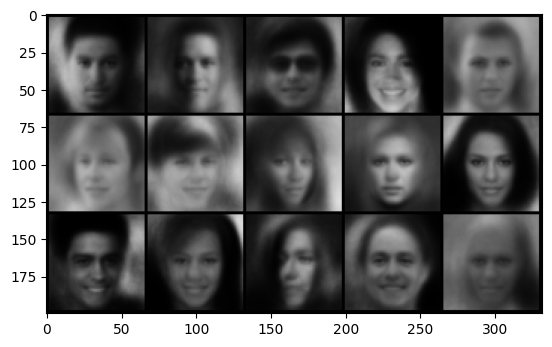

In [79]:
from IPython import display
from tqdm.auto import tqdm


losses_for_epochs = []
min_loss = 10000000000000.

for epoch in tqdm(range(10)):
    losses = []
    vae.train()
    for x, y in tqdm(train_loader):
        x = x.to(device)
        optimizer.zero_grad()

        mu_gen, logsigma_gen, mu_z, logsigma_z = vae(x)
        loss = loss_vae(x, mu_gen, logsigma_gen, mu_z, logsigma_z, "sum")

        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    scheduler.step()
    
    if np.mean(losses) < min_loss:
        min_loss = np.mean(losses)
        torch.save(vae.state_dict(), "vae.pth")

    losses_for_epochs.append(np.mean(losses))

    display.clear_output(wait=True)

    print(f'epoch: {epoch}')
    print(f'loss for epoch: {round(np.mean(losses), 5)}')
    print(f'min loss: {round(min_loss, 5)}')

    plt.plot(losses_for_epochs)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

    vae.eval()
    with torch.no_grad():
        z = torch.randn(15, 100).to(device)
        reconstruction_mu, reconstruction_logsigma = vae.decod(z)
        reconstruction = reconstruction_mu.reshape((15, 1, 64, 64)).cpu().clamp(0, 1)

    plt.imshow(make_grid(reconstruction, nrow=5).permute(1, 2, 0))
    plt.show()

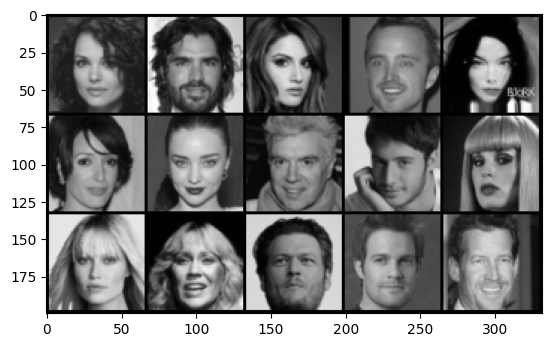

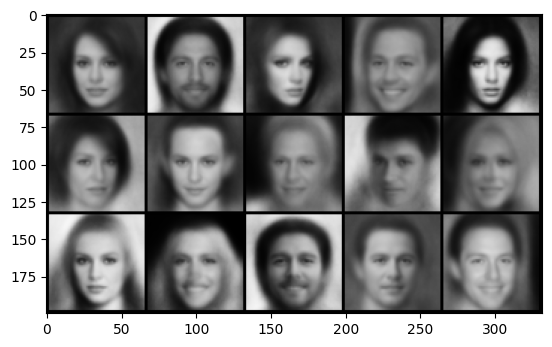

In [82]:
# восстановление 

vae.eval()

images, _ = list(islice(val_loader, 1))[0]
plt.imshow(make_grid(images[:15], nrow=5).permute(1, 2, 0))
plt.show()

with torch.no_grad():
    mu_gen, _, _, _ = vae(images.to(device))
    reconstruction = mu_gen[:15].reshape((15, 1, 64, 64)).cpu().clamp(0, 1)

plt.imshow(make_grid(reconstruction, nrow=5).permute(1, 2, 0))
plt.show()

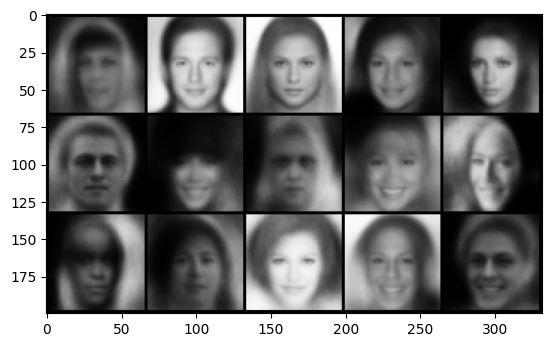

In [83]:
# генерация

vae.eval()
with torch.no_grad():
    z = torch.randn(15, 100).to(device)
    reconstruction_mu, reconstruction_logsigma = vae.decod(z)
    reconstruction = reconstruction_mu.reshape((15, 1, 64, 64)).cpu().clamp(0, 1)
plt.imshow(make_grid(reconstruction, nrow=5).permute(1, 2, 0))
plt.show()

In [60]:
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-03.


epoch: 9
loss for epoch: -2023.62969
min loss: -2023.62969


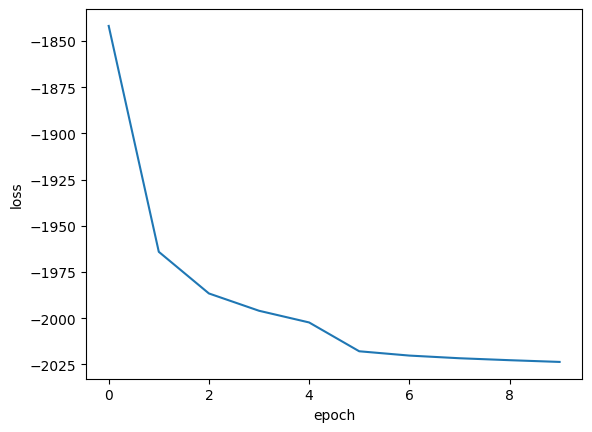

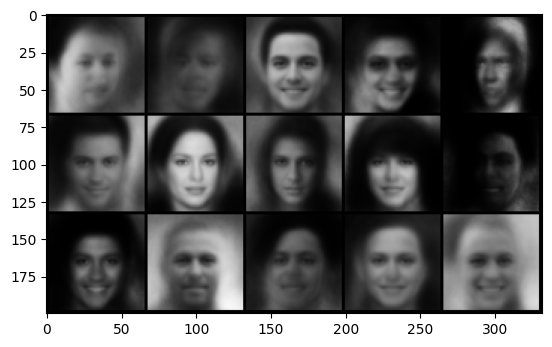

In [61]:
from IPython import display
from tqdm.auto import tqdm


losses_for_epochs = []
min_loss = 10000000000000.

for epoch in tqdm(range(10)):
    losses = []
    vae.train()
    for x, y in tqdm(train_loader):
        x = x.to(device)
        optimizer.zero_grad()

        mu_gen, logsigma_gen, mu_z, logsigma_z = vae(x)
        loss = loss_vae(x, mu_gen, logsigma_gen, mu_z, logsigma_z, "mean")

        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    scheduler.step()
    
    if np.mean(losses) < min_loss:
        min_loss = np.mean(losses)
        torch.save(vae.state_dict(), "vae.pth")

    losses_for_epochs.append(np.mean(losses))

    display.clear_output(wait=True)

    print(f'epoch: {epoch}')
    print(f'loss for epoch: {round(np.mean(losses), 5)}')
    print(f'min loss: {round(min_loss, 5)}')

    plt.plot(losses_for_epochs)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

    vae.eval()
    with torch.no_grad():
        z = torch.randn(15, 100).to(device)
        reconstruction_mu, reconstruction_logsigma = vae.decod(z)
        reconstruction = reconstruction_mu.reshape((15, 1, 64, 64)).cpu().clamp(0, 1)
    plt.imshow(make_grid(reconstruction, nrow=5).permute(1, 2, 0))
    plt.show()

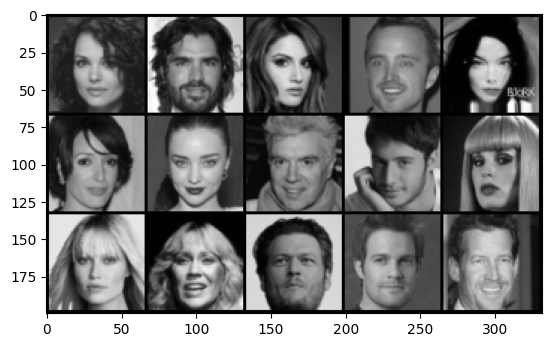

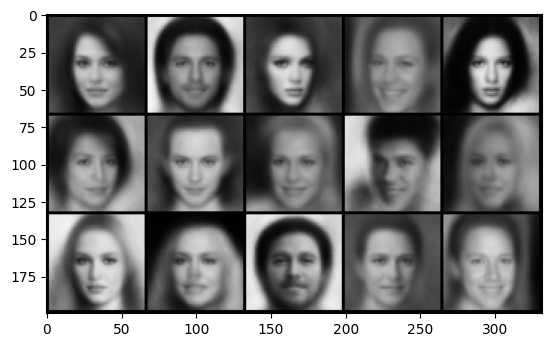

In [77]:
# восстановление 


vae.eval()

images, _ = list(islice(val_loader, 1))[0]
plt.imshow(make_grid(images[:15], nrow=5).permute(1, 2, 0))
plt.show()

with torch.no_grad():
    mu_gen, _, _, _ = vae(images.to(device))
    reconstruction = mu_gen[:15].reshape((15, 1, 64, 64)).cpu().clamp(0, 1)

plt.imshow(make_grid(reconstruction, nrow=5).permute(1, 2, 0))
plt.show()

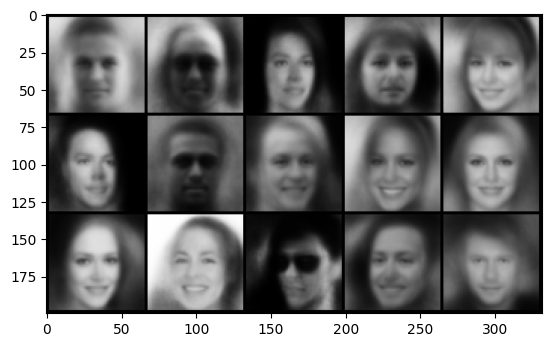

In [76]:
# генерация


vae.eval()

with torch.no_grad():
    z = torch.randn(15, 100).to(device)
    reconstruction_mu, reconstruction_logsigma = vae.decod(z)
    reconstruction = reconstruction_mu.reshape((15, 1, 64, 64)).cpu().clamp(0, 1)
plt.imshow(make_grid(reconstruction, nrow=5).permute(1, 2, 0))
plt.show()

Even if in practice you do not see the much difference between AE and VAE, or VAE is even worse, the little bayesian inside you should be jumping for joy right now. 

In VAE you can truly sample from image distribution $p(x)$, while in AE there is no easy and correct way to do it. 

# Congrats! and Bonus

If you managed to tune your autoencoders to converge and learn something about the world, now it's time to make fun out of it. As you may have noticed, there are face attributes in dataset. We're interesting in "Smiling" column (index 31 of the attribute vector), but feel free to try others as well! Here is the first task:

1) Extract the "Smilling" attribute and create a two sets of images: 10 smiling faces and 10 non-smiling ones.

2) Compute latent representations for each image in "smiling" set and average those latent vectors. Do the same for "non-smiling" set. You have found **"vector representation"** of the "smile" and "no smile" attribute.

3) Compute the difference: "smile" vector minus "non-smile" vector.

3) Now check if **"feature arithmetics"** works. Sample a face without smile, encode it and add the diff from p. 3. Check if it works with both AE and VAE. 

<img src="linear.png" alt="linear">